## Computer Vision (EECE 7219) Assignment #4
### University of Memphis, Spring 2023
#### Instructor: Dr. Yeasin

Bereket Kebede, Gradaute Student, EECE

## EigenFace Recognition Algorithm

1. Download the yale database containing face images.

2. Use this database to implement the EigenFace Recognition algorithm.

3. Use precision, recall, and F1-score to evaluate your model. For testing performance on non-face images, use cifar-10 dataset.

## Step 1. Dataset 
#### Training Images number = N = 105
#### Testing Images number = T = 30
## STEP 2. Flattening and then Represent the Image as Column Image Vector
## STEP 3. Compute the Average of Image vector and substract 
## STEP 4. Compute the Covarience Matrix
## STEP 5. Choose best k eigenvectors
## STEP 6. Find weights of each image and store it.

# Setup

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

'''__________________________USER SELECTED AREA___________________________'''
dirNameTrain = 'INPUT/TRAIN'
dirNameTest	 = 'INPUT/TEST'
OUT_Path     = 'OUT/'
reconstruct_Path = 'OUT/Reconstruct_All_eigen/'
reconstruct_K_Path ='OUT/Reconstruct_K_eigen/'

# Ratio, Selecting best eigen vectors
S1_ratio_S	 = 60


# Functions
#### Specify_K_eigenvalues:  
 to select best K eigenValues
#### WriteImages:            
 Convert the face vector to images and then Write the images
#### ReadFromFile:           
 to read a txt file as matrix
#### WritetoFile:            
 to save a matrix as txt
#### Find_Eigen:             
 Find eigenValues and eigenVectors of a Matrix
#### CreateDataMatrix:       
 Create Data Matrix which keeping the images as a single column
#### ReadImages:             
 Read all of the Images in a folder

In [2]:
# Select best K eigenValues
def Specify_K_eigenvalues(eigenValues, sum_eigenValues, percent):

    for i in range(0, len(eigenValues)):
        if ( ( np.sum(eigenValues[:i]) / sum_eigenValues ) * 100 ) > percent :
            return i

    return None

# Convert the face vector to images and then Write the images
def WriteImages(facevectors, size, path):

    for i in range(0, facevectors.shape[1]):
        image = facevectors[:,i].reshape(size)
        image = image.astype(int)
        cv2.imwrite(path + 'Resim' + str(i) + '.jpg', image)

    return True

# Read a txt file as matrix
def ReadFromFile(filename, string):
    print('reading -' + str(string) +  '- from' + str(filename), end=' ... ', flush=True)
    file = cv2.FileStorage(filename, cv2.FILE_STORAGE_READ)
    matrix = file.getNode(string).mat()
    file.release()
    print('DONE')
    return matrix

# Save a matrix as txt
def WritetoFile(filename, string, matrix):
    print('Writing -' + str(string) +  '- to ' + filename, end=' ... ', flush=True)
    file = cv2.FileStorage(filename, cv2.FILE_STORAGE_WRITE)
    file.write(str(string), matrix)
    file.release()
    print('DONE')

# Find eigenValues and eigenVectors of a Matrix
def Find_Eigen(matrix) :
    eigenVectors , eigenValues , _ = np.linalg.svd(matrix, full_matrices = False )
    sort = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[sort]
    eigenVectors = eigenVectors[:,sort]
    return eigenValues,eigenVectors

# Create Data Matrix which keeping the images as a single column
def CreateDataMatrix(images):
    print('Creating data matrix',end=' ... ', flush=True)
    
    numImages = len(images)
    sz = images[0].shape
    data = np.zeros(( sz[0] * sz[1], numImages), dtype=np.float32)
    for i in range(0, numImages):
        image = images[i].flatten()

        data[:,i] = image

    print('DONE')
    return data

# Read all of the Images in a folder
def ReadImages(path):
    print('Reading images from ' + path, end=' ... ', flush=True)
    # Create array of array of images.
    images = []
    # List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
        fileExt = os.path.splitext(filePath)[1]
        if fileExt in ['.jpg', '.jpeg', '.pgm']:
            # Add to array of images
            imagePath = os.path.join(path, filePath)
            im = cv2.imread(imagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

            if im is None :
                print('image:{} not read properly'.format(imagePath))
            else :
                # Convert image to floating point
                im = np.float32(im)
                # Add image to list
                images.append(im)
                # Flip image
                #imFlip = cv2.flip(im, 1);
                # Append flipped image
                #images.append(imFlip)

    numImages = len(images) / 2
    # Exit if no image found
    if numImages == 0 :
        print('No images found')
        sys.exit(0)

    print(str(numImages) + ' files read.')

    return images

### __A-)__ Read N face images from the training set and obtain the covariance matrix C.

In [3]:
    # Read images
    train_images = ReadImages(dirNameTrain)

    # Create face matrix for PCA.
    face_vector = CreateDataMatrix(train_images)

    # Size of images
    sz = train_images[0].shape
    number_train_images= face_vector.shape[1]

    # Find average_face_vector, sum(all image vectors)/number(images).
    average_face_vector = np.mean(face_vector, axis=1)
    average_face_vector.shape = (len(average_face_vector), 1)

    # Subtract average_face_vector from every image vector.
    sub_face_vector = np.zeros(face_vector.shape, dtype=np.float32)
    sub_face_vector = face_vector - average_face_vector

    # Calculate covariance matrix of above matrix -> C = A*transpose(A)
    covariance_matrix = np.dot(sub_face_vector.T, sub_face_vector)
    covariance_matrix /= number_train_images
    print("covariance_matrix.shape =", covariance_matrix.shape)

Reading images from INPUT/TRAIN ... 52.5 files read.
Creating data matrix ... DONE
covariance_matrix.shape = (105, 105)


#### __B-)__ Calculate eigen values of C and order them by using a sorting algorithm.
#### Report the details of your sorting algorithm. Plot the ordered E eigen values

> ## &nbsp; The Quick Sort
> QuickSort is a Divide and Conquer algorithm. It picks an element as pivot and partitions the given array around the picked pivot.<br> 
> There are many different versions of quickSort that pick pivot in different ways:
> 1. Always pick first element as pivot.
> 2. Always pick last element as pivot.
> 3. Pick a random element as pivot.
> 4. Pick median as pivot.<br>

> The key process in quickSort is partition(). Target of partitions is, given an array and an element x of array as pivot, <br> 
put x at its correct position in sorted array and put all > smaller elements (smaller than x) before x, and put all greater <br> 
elements (greater than x) after x. <br>

> __Worst Case:__ The worst case occurs when the partition process always picks greatest or smallest element as pivot.  $(N^2)$ <br>
> __Best Case:__ The best case occurs when the partition process always picks the middle element as pivot. $N\log_{}N$ <br>
> #### Why Quick Sort
> Quick Sort in its general form is an in-place sort (i.e. it doesn’t require any extra storage) whereas like merge sort requires O(N) extra storage,<br>
> N denoting the array size which may be quite expensive. Allocating and de-allocating the extra space used for merge sort increases the running time of the algorithm.<br> 
> Comparing average complexity that both type of sorts have O(NlogN) average complexity but the constants differ. For arrays, merge sort loses due to the use of<br> 
> extra O(N) storage space.



#### __C-)__ Calculate eigen vectors corresponding to E eigen values and
#### Write these vectors into a file named as EV.txt.

Calculating PCA  ... DONE
Writing -eigenVectors- to OUT/EV.txt ... DONE


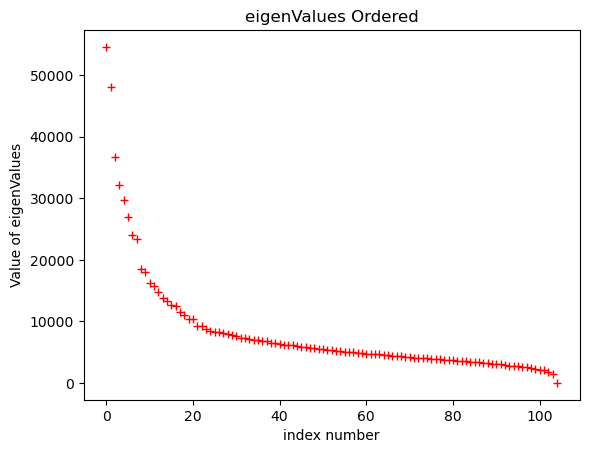

In [4]:
    # Find eigenvectors and eigenvalues of above covariance matrix.
    # eigenvalues arranged to match with associated eigenvector
    print('Calculating PCA ', end=' ... ', flush=True)
    eigenValues, eigenVectors = Find_Eigen(sub_face_vector)
    print ('DONE')

    # Plot the ordered eigen values.
    plt.plot(eigenValues, 'r+')
    plt.title('eigenValues Ordered')
    plt.ylabel('Value of eigenValues')
    plt.xlabel('index number')
    
    #Write the Eigen Vectors
    WritetoFile(OUT_Path + 'EV.txt','eigenVectors', eigenVectors)

## THE EIGENFACES:

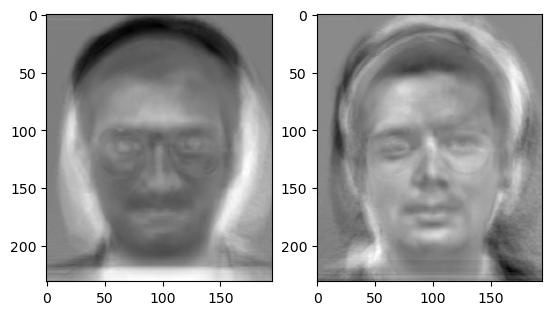

In [5]:
    plt.subplot(1,2,1)
    plt.imshow(eigenVectors[:,0].reshape(sz), cmap= 'gray')
    plt.subplot(1,2,2)
    plt.imshow(eigenVectors[:,7].reshape(sz), cmap= 'gray')

#### __D-)__ Transform the used N face images into a new vector space V by using all of the eigenvectors (Use EV.txt).

#### Write the weights into Weights.txt.

In [6]:
    # Calculate weights
    weights = np.dot(eigenVectors.T, sub_face_vector)
    
    # Write weights
    WritetoFile(OUT_Path + 'Weights.txt','Weights', weights)

Writing -Weights- to OUT/Weights.txt ... DONE


#### __E-)__ Reconstruct N face images as a linear combination of bases of the space 'V'
#### (use EV.txt and Weights.txt). Write the reconstructed images as jpg files.

In [ ]:
    # Read eigenVectors from file
    eigenVectors = ReadFromFile(OUT_Path + 'EV.txt', 'eigenVectors')
    
    # Reconstruct from 'V' Space
    reconstructed_image_vector = average_face_vector + np.dot(eigenVectors, weights)
    
    print('reconstructed_image_vector.shape =', reconstructed_image_vector.shape)
    
    # Write Reconstructed Images
    Is_Okey = WriteImages(reconstructed_image_vector, sz, reconstruct_Path)
    
    if Is_Okey :
        print ("Succesfully! images are written")
    else: 
        print ("Error! images are not written")
    

reading -eigenVectors- fromOUT/EV.txt ... 

#### --Showing the reconstructed image (left) and original image (right)

In [ ]:
    plt.subplot(1,2,1)
    plt.title('reconstructed image')
    plt.imshow(plt.imread(reconstruct_Path + "Resim2.jpg"), cmap= 'gray')

    plt.subplot(1,2,2)
    plt.title('original image')
    plt.imshow(plt.imread(dirNameTrain + "/subject01.normal.pgm"), cmap= 'gray')


#### __F-)__ Calculate the difference images between original and reconstructed
#### Calculate the mean squared error and report the reconstruction error RE1.

In [ ]:
    #Mean Square error between all original and reconstructed images
    MSE = np.sum( np.square(face_vector - reconstructed_image_vector) ) / (face_vector.shape[1] * face_vector.shape[0] )
    print('Mean Squared Error of the reconstructed face RE1: ' + str(MSE))

#### __G-)__ Report sum of E eigen values as S.
#### __-__ Specify K, the number of important eigen values by checking the ratio of (S1/S)
#### where S1 denotes sum of the used eigen values.

#### __-__ Write the selected eigen vectors into a file named as EVK.txt.

In [ ]:
    # sum of eigen values
    print('Calculating the sum of the Eigen Values', end=' ... ', flush=True)
    sum_eigenValues = np.sum(eigenValues)
    print('DONE')
    print('*** Sum of the Eigen Values = ' + str(sum_eigenValues))

    # Calculate the important eigen values
    print('Calculating the Number of Important Eigen Values for S1/S = %' + str(S1_ratio_S), end=' ... ', flush=True)
    K = Specify_K_eigenvalues(eigenValues, sum_eigenValues, S1_ratio_S)
    print('DONE')
    print('*** Total Number of Eigen Values = {} the number of important eigen values K= {}, %{}'.format(len(eigenValues), K, S1_ratio_S) )

    # Select important eigen values
    selected_eigenVectors = eigenVectors[:,0:K]
    
    # Plot the ordered eigen values.
    plt.plot(eigenValues[:K], 'b^', eigenValues, 'r+')
    plt.legend(('Selected','All'))
    plt.title('eigenValues Ordered')
    plt.ylabel('Value of eigenValues')
    plt.xlabel('index number')
    
    # Writing the selected eigen vectors
    WritetoFile(OUT_Path + 'EVK.txt','selected_eigenvalues', selected_eigenVectors )

#### __H-)__ Transform the used N face images into a new vector space VK
#### by using selected K eigen vectors (Use EVK.txt).
#### __-__ Write the weights into WeightsK.txt.

In [ ]:
    # Transform the Images in  VK space using K eigenVectors
    weightsK = np.dot(selected_eigenVectors.T, sub_face_vector)

    # Writes the weights
    WritetoFile(OUT_Path + 'WeightsK.txt','WeightsK', weightsK)

#### __I-)__ Repeat steps (E) and (F) for the new vector space VK and
#### report the reconstruction error RE2. (use EVK.txt and WeightsK.txt).

In [ ]:
    # Reconstruct from 'VK' Space
    reconstructed_image_vectorK = average_face_vector + np.dot(selected_eigenVectors, weightsK)
    
    # Write reconstructed images
    WriteImages(reconstructed_image_vectorK, sz, reconstruct_K_Path)
    
    #Calculate Mean Square Error
    MSE_K = np.sum( np.square(face_vector - reconstructed_image_vectorK) ) / (face_vector.shape[1] * face_vector.shape[0] )
    print('Mean Squared Error of the reconstructed face RE2: ' + str(MSE_K))

#### __--__ Showing the reconstructed image (left) and original image (right). (K eigenvectors) 

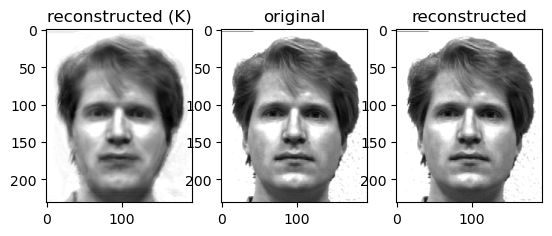

In [13]:
    plt.subplot(1,3,1)
    plt.title('reconstructed (K)')
    plt.imshow(plt.imread(reconstruct_K_Path + "Resim2.jpg"), cmap= 'gray')

    plt.subplot(1,3,2)
    plt.title('original')
    plt.imshow(plt.imread(dirNameTrain + "/subject01.normal.pgm"), cmap= 'gray')
    
    plt.subplot(1,3,3)
    plt.title('reconstructed')
    plt.imshow(plt.imread(reconstruct_Path + "Resim2.jpg"), cmap= 'gray')
    

#### __J-)__ Compare RE1 and RE2. Are they equal or not? Why?

 #### $RE_1 = 5^{-10}$ and $ RE_2 = 366$
> The errors are not equal because of the their's eigenvectors. We choosed the best (higher) eigenvalues and we used the eigenvectors corresponding to this eigenvalues <br> 
but still there is a little bit information in the unselected eigenvectors.

#### __K-)__ Read T face images from the test set and transform them into the vector space V by using EV.txt.

#### __-__ Write the weights into WeightsT.txt.

In [14]:
    # Read test images
    test_images = ReadImages(dirNameTest)

    # Create face matrix for PCA.
    test_face_vector = CreateDataMatrix(test_images)

    # Find average_face_vector, sum(all image vectors)/number(images).
    average_test_face_vector = test_face_vector - average_face_vector

    # Read the eigenVectors from EV.txt
    eigenVectors = ReadFromFile(OUT_Path + 'EV.txt', 'eigenVectors')
    
    #Transform the test images to 'V' space
    weights_test = np.dot(eigenVectors.T, average_test_face_vector)
    
    #Write Test Weights
    WritetoFile(OUT_Path + 'WeightsT.txt','WeightsT', weights_test)

Reading images from INPUT/TEST ... 15.0 files read.
Creating data matrix ... DONE
reading -eigenVectors- fromOUT/EV.txt ... DONE
Writing -WeightsT- to OUT/WeightsT.txt ... DONE


#### __L-)__ Calculate the Euclidean distance between each of T test images and N training images.
#### Match the test images to the one training image that minimizes the Euclidean distance
#### (Use Weights.txt and WeightsT.txt).
#### __-__ Count the number of correctly matched faces and report it as TP.

In [15]:
    # Create array to keep matched images
    Matched_Faces = np.zeros((weights_test.shape[1]))

    # Compare all weights_test among the weights and Calculate Similarity
    for i in range(0, weights_test.shape[1]):
        error = np.zeros((weights.shape[1]))
        for j in range (0, weights.shape[1]):
            error[j] = (np.sum((weights[:, j] - weights_test[:, i])**2))

        # Match the test image with training image 
        Matched_Faces[i] = error.argmin() // 7
        
    # Print the indexes of matched images
    print(Matched_Faces)

[ 0.  0.  1.  1.  2.  2.  3.  3.  4.  4.  5.  5. 13.  6.  7.  7.  8.  8.
  9.  9. 10. 10. 11. 11. 12. 12. 13. 13. 14. 14.]


### -- __TP__ = 29 out of 30, $\%97$ Accuracy

#### __M-)__ Repeat (K) and (L) by using EVK.txt.
#### __-__ Write the weights into WeightsTK.txt.
#### __-__ Apply matching by using WeightsK.txt and WeightsTK.txt.
#### __-__ Count the number of correctly matched faces and report it as TPK.

In [16]:
    #Transform the test images to 'VK' space
    weights_test_K = np.dot(selected_eigenVectors.T, average_test_face_vector)
    
    #Write Test Weights K
    WritetoFile(OUT_Path + 'WeightsTK.txt','WeightsTK', weights_test_K)
    
    # Create array to keep matched images
    Matched_Faces_K = np.zeros((weights_test_K.shape[1]))

    # Compare all weights_test_K among the weights_K and Calculate Similarity
    for i in range(0, weights_test_K.shape[1]):
        error_K = np.zeros((weights.shape[1]))
        for j in range (0, weights.shape[1]):
            AAA = np.pad(weights_test_K[:, i], (0, weights.shape[0] - weights_test_K.shape[0]), 'constant')
            error_K[j] = (np.sum((weights[:, j] - AAA)**2))
        
        # Match the test image with training image 
        Matched_Faces_K[i] = error_K.argmin() // 7
    
    # Print the indexes of matched images
    print(Matched_Faces_K)

Writing -WeightsTK- to OUT/WeightsTK.txt ... DONE
[ 0.  0.  1.  1.  2.  2.  3.  3.  4.  4.  5.  5.  3.  6.  7.  7.  8.  8.
  9.  9. 10. 10. 11. 11. 12. 12. 13. 13. 14. 14.]


* __TPK__ = 29 out of 30, $\%97$ Accuracy $\frac{S1}{S}=\%80 $ K = __57__ 
* __TPK__ = 29 out of 30, $\%97$ Accuracy $\frac{S1}{S}=\%70 $ K = __41__ 
* __TPK__ = 29 out of 30, $\%97$ Accuracy $\frac{S1}{S}=\%60 $ K = __29__ (SELECTED) 
* __TPK__ = 28 out of 30, $\%93$ Accuracy $\frac{S1}{S}=\%50 $ K = __19__ 
* __TPK__ = 24 out of 30, $\%80$ Accuracy $\frac{S1}{S}=\%30 $ K = __08__
* Total EigenValues: 105 

#### __O-)__ Repeat (K) and (L) by using face images recorded in the training set as test images.
#### Report the number of correctly matched images as TPT.
#### Compare TPT and TP and comments on your face verification accuracy.

In [17]:
    # We already have training weights in 'weights'
    
    # Create array to keep matched images
    Matched_Faces_training = np.zeros((weights.shape[1]))
    
    for i in range(0, weights.shape[1]):
        error_K = np.zeros((weights.shape[1]))
        for j in range (0, weights.shape[1]):
            AAA = np.pad(weights[:, i], (0, weights.shape[0] - weights.shape[0]), 'constant')
            error_K[j] = (np.sum((weights[:, j] - AAA)**2))
        
        # Match the test image with training image 
        Matched_Faces_training[i] = error_K.argmin() // 7
    
    # Print the indexes of matched images
    print(Matched_Faces_training)

[ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.
  7.  7.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9. 10. 10.
 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12.
 12. 13. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 14. 14.]


## __TPT__ = 105 out of 105, %100 accuracy

> $TPT = \%100 $ and $TP =\%97$. When testing with the 'training set', the accuracy must be %100 because <br> 
the system already trained the same images and also it used all of the eigenvectors. <br> 
On the other hand; the system doesn't see the 'test set', so the accuracy depends that the system is how much learn the face features